In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./src')
sys.path.append('..')

In [3]:
import comet_ml

from src.data.toy import (
    DiscreteGaussianDataset, 
    DiscreteSwissRollDataset, 
    DiscreteUniformDataset,
    DiscreteMixtureGaussianDataset
)
import itertools
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from tqdm.notebook import tqdm
from comet_ml import Experiment
from PIL import Image
import numpy as np

from src.data.prior import Prior
from src.methods.light_sb_d import LightSB_D, AutoregressiveLightSB_D
from src.utils.visualization import fig2img, plot_samples
#from src.benchmark.benchmark import BenchmarkDiscreteEOT

In [4]:
#comet_ml.login()

In [7]:
DIMS           = [16]#[2, 16, 64]
NUM_CATEGORIES = 100
NUM_POTENTIALS = 1000 #100
D_LR           = 4e-4 #5e-3#1e-4
DEVICE         = 'cuda'
BATCH_SIZE     = 1024
N_EPOCHS       = 20000
PRIOR_TYPES    = ['gaussian_log']#['gaussian_log', 'uniform']
P0             = 'gaussian'
EXP_TYPE       = 'benchmark'
DIST_INITS     = ['gaussian']#['gaussian', 'uniform']
NUM_STEPS      = 16
NUM_SKIP_STEPS = 8
D_GRADIENT_MAX_NORM = float("inf")
BETAS          = {'uniform':[0.01, 0.005], 'gaussian_log':[0.02, 0.05], 'gaussian':[0.02, 0.05]}
comet_report = True
    
config = dict(
              NUM_CATEGORIES = NUM_CATEGORIES,
              NUM_POTENTIALS = NUM_POTENTIALS,
              D_LR           = D_LR,
              DEVICE         = DEVICE,
              BATCH_SIZE     = BATCH_SIZE,
              NUM_STEPS      = NUM_STEPS,
              NUM_SKIP_STEPS = NUM_SKIP_STEPS,
              N_EPOCHS       = N_EPOCHS)

if comet_report:
    comet_online = True #'disabled'
else:
    comet_online = False

combinations = list(itertools.product(DIMS, PRIOR_TYPES, DIST_INITS))

{'NUM_CATEGORIES': 100, 'NUM_POTENTIALS': 1000, 'D_LR': 0.0004, 'DEVICE': 'cuda', 'BATCH_SIZE': 1024, 'NUM_STEPS': 16, 'NUM_SKIP_STEPS': 8, 'N_EPOCHS': 20000, 'DIM': 16, 'PRIOR_TYPE': 'gaussian_log', 'DIST_INIT': 'gaussian', 'BETA': 0.02}


COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/xavier-aramayo-carrasco/benchmarklightsb-d-dim-16-p0-gaussian-prior-type-gaussian-log-num-categories-100/b0ee43d8078c40928889cfda173e31f3



  0%|          | 0/20000 [00:00<?, ?it/s]

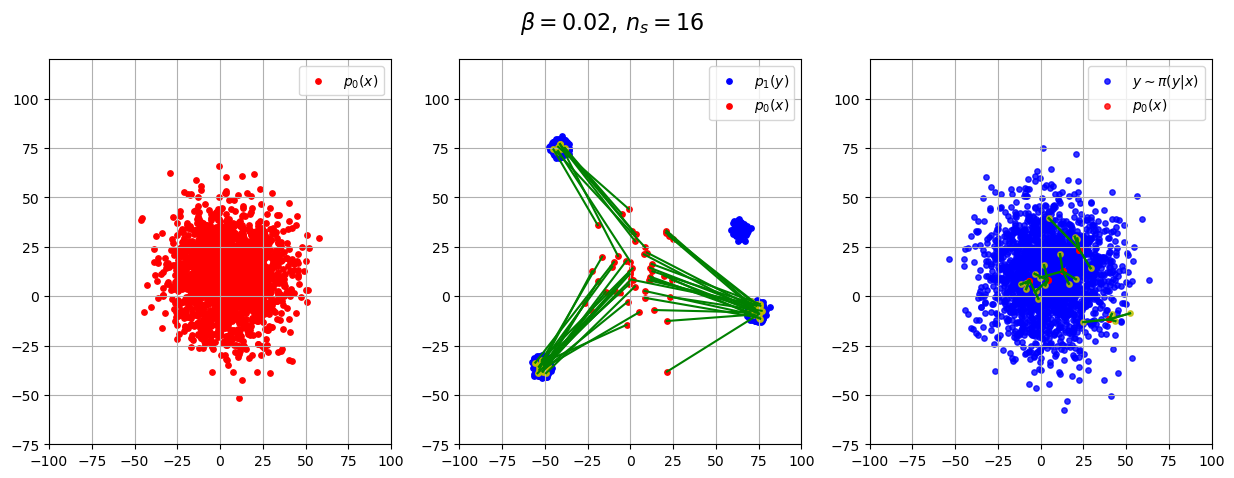

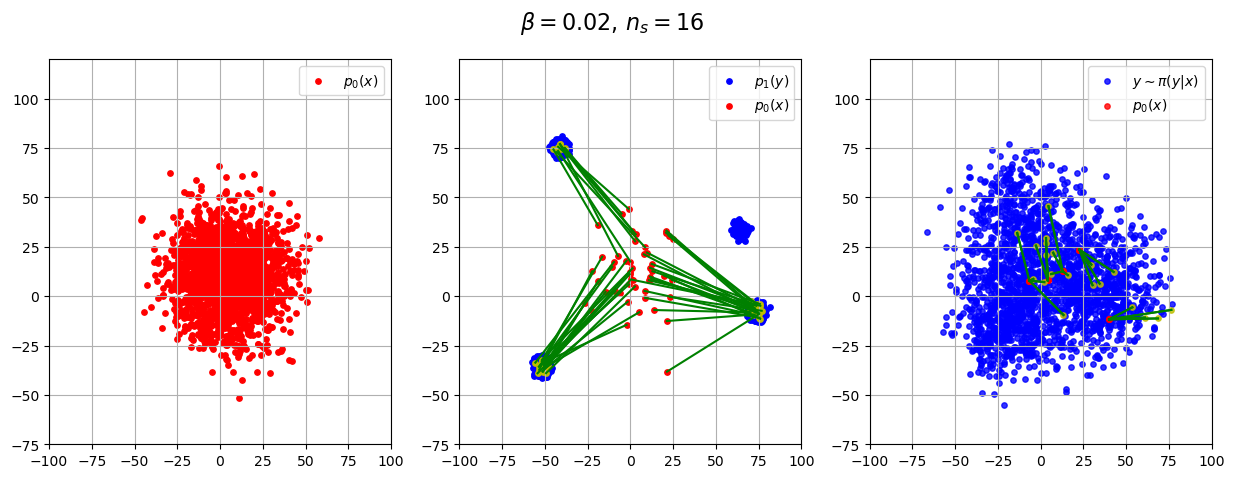

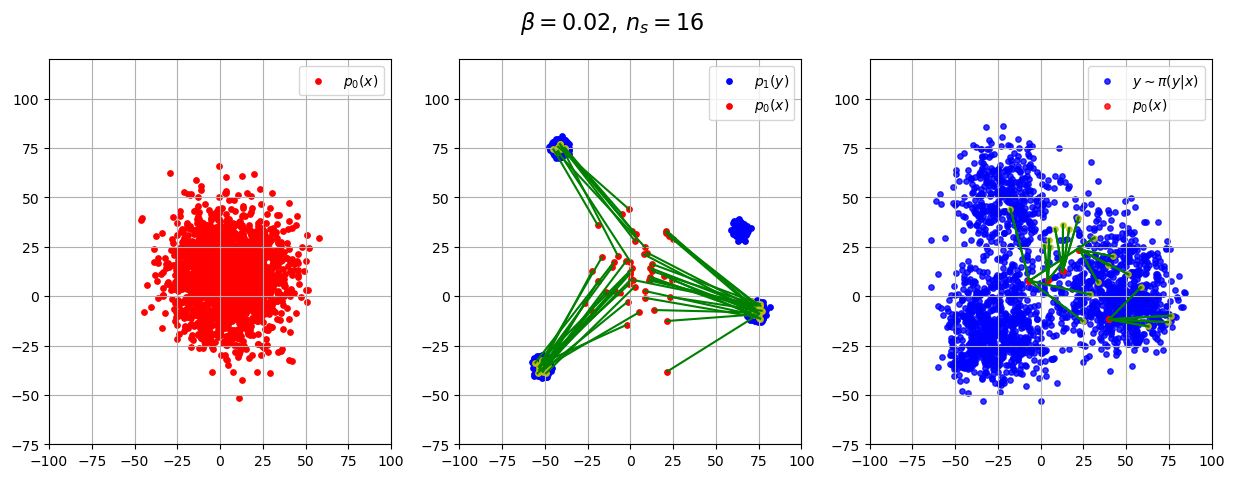

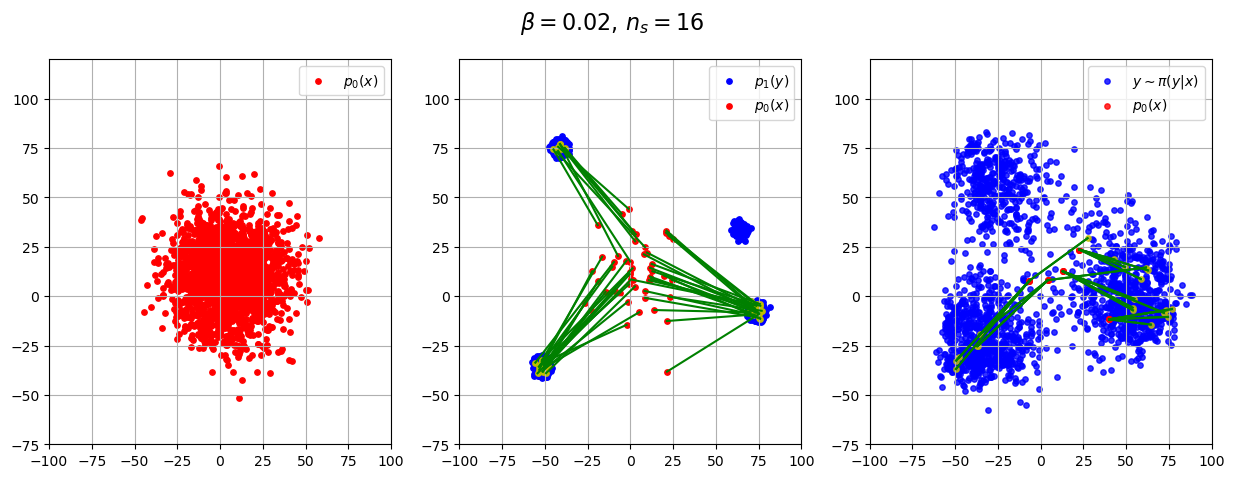

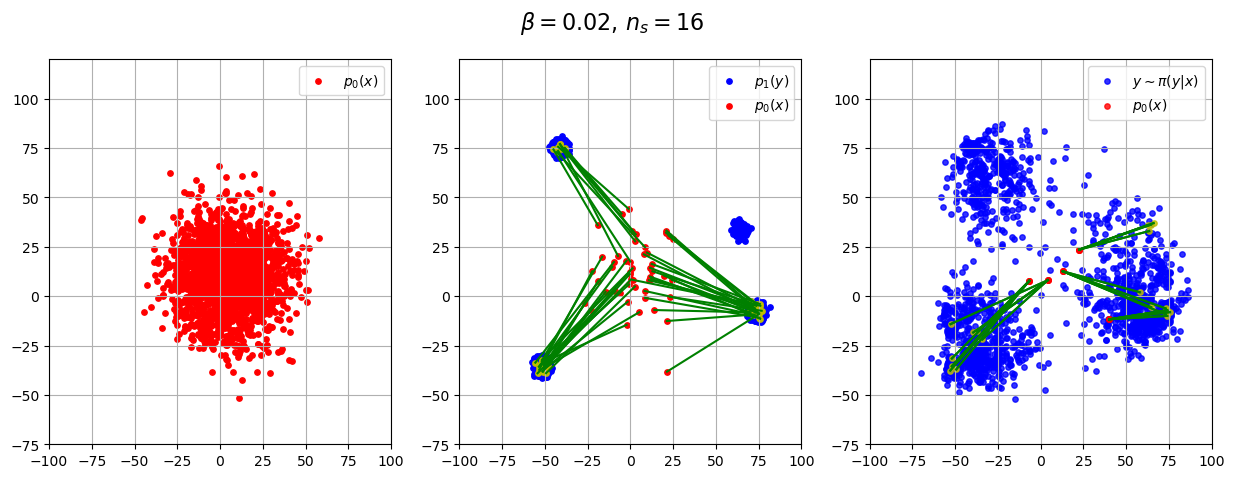

{'NUM_CATEGORIES': 100, 'NUM_POTENTIALS': 1000, 'D_LR': 0.0004, 'DEVICE': 'cuda', 'BATCH_SIZE': 1024, 'NUM_STEPS': 16, 'NUM_SKIP_STEPS': 8, 'N_EPOCHS': 20000, 'DIM': 16, 'PRIOR_TYPE': 'gaussian_log', 'DIST_INIT': 'gaussian', 'BETA': 0.05}
The configuration X0_benchmark_dim_16_P0_gaussian_prior_gaussian_log_num_categories_100_alpha_0.05 does not exist...


In [8]:

xranges = {2:[0, 100], 16:[-100, 100], 64:[-150,150]}#[0, NUM_CATEGORIES]  
yranges = {2:[0, 100], 16:[-75, 120], 64:[-200,150]}#[0, NUM_CATEGORIES]  
N_TEST = 2000


for combination in combinations:
    DIM         = combination[0]
    PRIOR_TYPE  = combination[1]
    DIST_INIT   = combination[2]
       
    for BETA in BETAS[PRIOR_TYPE]:
        config['DIM']        = DIM
        config['PRIOR_TYPE'] = PRIOR_TYPE
        config['DIST_INIT']  = DIST_INIT
        config['BETA']       = BETA
        
        print(config)
        if EXP_TYPE == 'benchmark':
            try:
                X0_full = torch.load(f'../benchmark_data/X0_benchmark_dim_{DIM}_P0_{P0}_prior_{PRIOR_TYPE}_num_categories_{NUM_CATEGORIES}_alpha_{BETA}.pt')
                X1_full = torch.load(f'../benchmark_data/X1_benchmark_dim_{DIM}_P0_{P0}_prior_{PRIOR_TYPE}_num_categories_{NUM_CATEGORIES}_alpha_{BETA}.pt')
        
                X0_test = X0_full[-N_TEST:]
                X1_test = X1_full[-N_TEST:]
                
            except:
                name = f'X0_benchmark_dim_{DIM}_P0_{P0}_prior_{PRIOR_TYPE}_num_categories_{NUM_CATEGORIES}_alpha_{BETA}'
                print(f'The configuration {name} does not exist...')
                continue
            
        else:
            if P0 == 'gaussian':
                X0_test = DiscreteGaussianDataset(num_samples=N_TEST, dim=DIM, num_categories=NUM_CATEGORIES, train=True).dataset
                X1_test = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=NUM_CATEGORIES).dataset
            if P0 == 'uniform':
                X0_test = DiscreteUniformDataset(num_samples=N_TEST, dim=DIM, num_categories=NUM_CATEGORIES, train=True).dataset
                X1_test = DiscreteSwissRollDataset(num_samples=N_TEST, num_categories=NUM_CATEGORIES).dataset
        
        indices_test = torch.arange(0, N_TEST)
    
        X0_test = X0_test.to(torch.int32).to(DEVICE)
        X1_test = X1_test.to(torch.int32).to(DEVICE)
        indices_plot = torch.randint(0, len(X0_test), (50,))

        exp_name = f'LightSB_D_beta_{BETA}_dist_init_{DIST_INIT}'
        experiment_config = comet_ml.ExperimentConfig(name=exp_name)
        exp = comet_ml.start(project_name=f"BenchmarkLightSB_D_DIM_{DIM}_P0_{P0}_PRIOR_TYPE_{PRIOR_TYPE}_NUM_CATEGORIES_{NUM_CATEGORIES}", experiment_config=experiment_config, 
                             online=comet_online, mode='create')
        exp.log_parameters(config)
    
        prior = Prior(BETA, NUM_CATEGORIES, NUM_STEPS, NUM_SKIP_STEPS, PRIOR_TYPE)
        D = LightSB_D(prior=prior, dim=DIM, num_potentials=NUM_POTENTIALS, distr_init=DIST_INIT, optimizer=None).to(DEVICE)
        
        #D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
        D_opt = torch.optim.AdamW(D.parameters(), lr=D_LR)
        
        for step in tqdm(range(N_EPOCHS)):
            D.train()
            D_opt.zero_grad()    
    
            if EXP_TYPE == 'benchmark':
                indices = torch.randint(high=len(X0_full) - N_TEST, size=(BATCH_SIZE,))
                X0 = X0_full[indices]
                X1 = X1_full[indices]
            else:
                if P0 == 'gaussian':
                    X0 = DiscreteGaussianDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=NUM_CATEGORIES).dataset
                    X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=NUM_CATEGORIES).dataset
                    
                if P0 == 'uniform':
                    X0 = DiscreteUniformDataset(num_samples=BATCH_SIZE, dim=DIM, num_categories=NUM_CATEGORIES).dataset
                    X1 = DiscreteSwissRollDataset(num_samples=BATCH_SIZE, num_categories=NUM_CATEGORIES).dataset
                 
            X0 = X0.to(torch.int32).to(DEVICE)
            X1 = X1.to(torch.int32).to(DEVICE)
        
            log_potential = D.get_log_v(X1)
            log_C         = D.get_log_c(X0)
            
            D_loss = (-log_potential + log_C).mean()
            #wandb.log({'D_loss':D_loss.item()}, step=step)
            exp.log_metrics({'D_loss': D_loss.item(), 'log_v': log_potential.mean().item(), 'log_c':log_c.mean().item()}, step=step)
            D_loss.backward()
            D_gradient_norm = torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=D_GRADIENT_MAX_NORM)
            D_opt.step()    
        
            if step % 5000==0 or step==N_EPOCHS-1:
                D.eval()
                X1_pred = D.sample(X0_test).detach()#.cpu()
                fig = plot_samples(X0_test, X1_test, D, indices_plot, BETA, NUM_STEPS, xranges[DIM], yranges[DIM], plot_trajectories=True, by_dims=False, index_0=2, index_1=3)
                exp.log_figure(figure=fig, figure_name="Prediction plot")
    
                plt.show()
                plt.close()
      

In [14]:
torch.save(D.state_dict(), f'../benchmark_data/D_dim_{DIM}_p0_{P0}_prior_{PRIOR_TYPE}_num_categories_{NUM_CATEGORIES}_beta_{BETA}.pth')

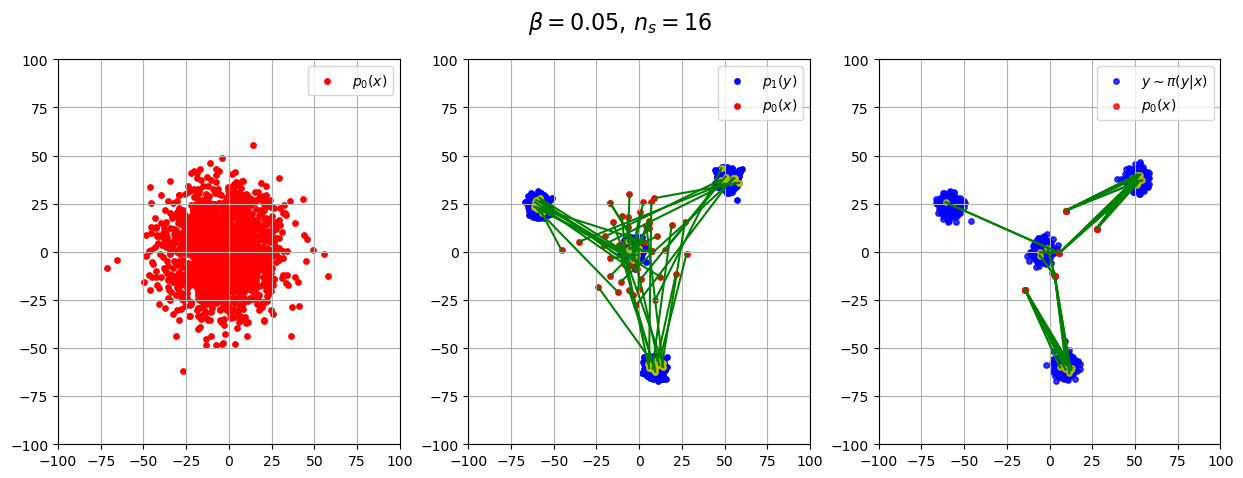

In [21]:
prior = Prior(0.05, NUM_CATEGORIES, NUM_STEPS, NUM_SKIP_STEPS, PRIOR_TYPE)
D = LightSB_D(prior=prior, dim=DIM, num_potentials=500, distr_init=DIST_INIT, optimizer=None).to(DEVICE)
    
D.load_state_dict(torch.load('../benchmark_data/D_dim_64_p0_gaussian_prior_gaussian_log_num_categories_100_beta_0.05.pth', weights_only=True))
D.eval()
X1_pred = D.sample(X0_test).detach()#.cpu()
fig = plot_samples(X0_test, X1_test, D, indices_plot, BETA, NUM_STEPS, xrange, yrange, plot_trajectories=True, by_dims=False, index_0=2, index_1=3)

In [ ]:
from torch.distributions.mixture_same_family import MixtureSameFamily
from torch.distributions.categorical import Categorical
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.independent import Independent
from torch.distributions.normal import Normal
import numpy as np
import torch
from typing import Tuple, Union, Optional
from sklearn.decomposition import PCA


dim = 64
num_potentials = 4
num_categories = 100
probs = torch.ones((num_potentials,))/num_potentials
spread = 0.5

def _continuous_to_discrete(
    batch: Union[torch.Tensor, np.ndarray], 
    num_categories: int,
    quantize_range: Optional[Tuple[Union[int, float], Union[int, float]]] = None
):
    if isinstance(batch, np.ndarray):
        batch = torch.tensor(batch).contiguous()
    if quantize_range is None:
        quantize_range = (-3, 3)
    bin_edges = torch.linspace(
        quantize_range[0], 
        quantize_range[1], 
        num_categories - 1
    )
    discrete_batch = torch.bucketize(batch, bin_edges)
    return discrete_batch
    
def get_means(dim: int, num_clusters: int = 4, min_separation: float = 0, seed: int = 43):
    torch.manual_seed(seed)
    means_hd = torch.zeros((num_clusters, dim))


    for k in range(1, num_clusters):
        candidate = torch.empty(dim)
        valid = False
        candidate.uniform_(-2, 2)
        means_hd[k] = candidate

    return means_hd
    
means = get_means(dim, num_potentials)
covs = torch.eye(dim).repeat(num_potentials, 1, 1) * (spread ** 2)

# 3. Create mixture model components
probs = torch.ones(num_potentials) / num_potentials  # Uniform weights
mix = Categorical(probs=probs)
comp = MultivariateNormal(loc=means, covariance_matrix=covs)
gmm = MixtureSameFamily(mix, comp)

continuous_samples = gmm.sample((1024,))

samples = _continuous_to_discrete(continuous_samples, num_categories=num_categories, quantize_range=(-15, 15))

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

pca = PCA(n_components=2)
pca.fit(samples)
samples_pca = pca.transform(samples)
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.3, s=5, c='mediumorchid')
ax2.scatter(samples_pca[:, 0], samples_pca[:, 1], alpha=0.3, s=5, c='mediumorchid')

ax.set_title("3D Circular Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
#plt.tight_layout()
plt.show()

In [ ]:
def DiscreteGaussianMixture(
    n_samples: int = 10000,
    n_categories: int = 100,
    n_clusters: int = 4,
    radius: float = 10.0,
    z_level: float = 0.0,
    spread: float = 0.8,
    quantize_range: Tuple[float, float] = (-15, 15),
    seed: int = 42
) -> torch.Tensor:

    np.random.seed(seed)
    torch.manual_seed(seed)
    
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)

    means = np.stack([
        radius * np.cos(angles),
        radius * np.sin(angles),
        np.full(n_clusters, z_level)
    ], axis=1)

    covs = [np.eye(3) * spread for _ in range(n_clusters)]
    weights = np.ones(n_clusters) / n_clusters

    samples = []
    for k in range(n_clusters):
        n_k = int(weights[k] * n_samples)
        continuous_samples = np.random.multivariate_normal(mean=means[k], cov=covs[k], size=n_k)
        discrete = _continuous_to_discrete(continuous_samples, num_categories=n_categories, quantize_range=quantize_range)
        samples.append(discrete)
    samples = torch.cat(samples, dim=0)  # shape: (n_samples, 3)
    return samples

In [ ]:
import torch
import math
from src.data.toy import _continuous_to_discrete

def swissroll_3d(
    num_samples: int = 1000,
    num_categories = 100,
) -> torch.Tensor:

    points = make_swiss_roll(
            n_samples=num_samples,
            noise=0.01
        )[0][:, [0, 1, 2]]  / 7.5
    points = _continuous_to_discrete(points, num_categories)
    return points

def plot_swissroll(points):
    """Plot 3D Swiss Roll using matplotlib."""
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    x, y, z = points[:, 0], points[:, 1], points[:, 2]
    ax.scatter(x, y, z, cmap='viridis', s=10, alpha=0.8)
    
    ax.set_title('3D Swiss Roll Dataset')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

# Example usage
if __name__ == "__main__":
    # Generate 2000 points with moderate noise and thickness
    points = swissroll_3d(
        num_samples=2000,
        num_categories=100
    )
    
    # Visualize
    plot_swissroll(points)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import multivariate_normal

# Parameters
D = 3
K = 4                 # number of components
n_samples = 10000     # total number of points

np.random.seed(42)

# Define Gaussian mixture parameters
means = np.random.uniform(0, 10, size=(K, D))
covs = np.array([np.diag(np.random.uniform(0.5, 1.5, size=D)) for _ in range(K)])
weights = np.random.dirichlet(np.ones(K))

# Sample from mixture
samples = []
for i in range(K):
    n_k = int(weights[i] * n_samples)
    samples.append(np.random.multivariate_normal(mean=means[i], cov=covs[i], size=n_k))
samples = _continuous_to_discrete(np.concatenate(samples, axis=0), 100)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.3, s=5, c='steelblue')
ax.set_title("3D Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA


def _continuous_to_discrete(
    batch: Union[torch.Tensor, np.ndarray], 
    num_categories: int,
    quantize_range: Optional[Tuple[Union[int, float], Union[int, float]]] = None
):
    if isinstance(batch, np.ndarray):
        batch = torch.tensor(batch).contiguous()
    if quantize_range is None:
        quantize_range = (-3, 3)
    bin_edges = torch.linspace(
        quantize_range[0], 
        quantize_range[1], 
        num_categories - 1
    )
    discrete_batch = torch.bucketize(batch, bin_edges)
    return discrete_batch
# Parameters
K = 4                  # number of components
n_samples = 10000      # total samples
radius = 10
z_level = 0            # set to 0 for flat circle; change to a function of theta for helix
spread = 0.8           # how wide each Gaussian is
dim_hd = 16
# Circle angles
angles = np.linspace(0, 2 * np.pi, K, endpoint=False)

# Means on a circle in XY plane
means = np.stack([
    radius * np.cos(angles),
    radius * np.sin(angles),
    np.full(K, z_level)  # z = constant
], axis=1)

covs = [np.eye(3) * spread for _ in range(K)]
weights = np.ones(K) / K

# Sample from the mixture
samples = []
np.random.seed(42)
for k in range(K):
    n_k = int(weights[k] * n_samples)
    sample = _continuous_to_discrete(np.random.multivariate_normal(mean=means[k], cov=covs[k], size=n_k), 100, quantize_range=(-15, 15))
    samples.append(sample)
samples = np.concatenate(samples, axis=0)

# Plot
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)


pca = PCA(n_components=2)
pca.fit(samples)
samples_pca = pca.transform(samples)
ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], alpha=0.3, s=5, c='mediumorchid')
ax2.scatter(samples_pca[:, 0], samples_pca[:, 1], alpha=0.3, s=5, c='mediumorchid')

ax.set_title("3D Circular Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
#plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

def _continuous_to_discrete(
    batch, 
    num_categories: int,
    quantize_range = None
):
    if isinstance(batch, np.ndarray):
        batch = torch.tensor(batch).contiguous()
    if quantize_range is None:
        quantize_range = (-15, 15)
    bin_edges = torch.linspace(
        quantize_range[0], 
        quantize_range[1], 
        num_categories - 1
    )
    discrete_batch = torch.bucketize(batch, bin_edges)
    return discrete_batch.numpy()  # Convert back to numpy

# Parameters
K = 5                   # Number of components
n_samples = 10000       # Total samples
radius = 10             # Radius of the circle for means
spread = 0.8            # Standard deviation for each Gaussian
dim_hd = 16             # High dimension size

# Create means in a circle in the first two dimensions
angles = np.linspace(0, 2 * np.pi, K, endpoint=False)
means_2d = radius * np.column_stack([np.cos(angles), np.sin(angles)])

# Embed means in high-dimensional space (other dimensions = 0)
means_hd = np.zeros((K, dim_hd))
means_hd[:, :2] = means_2d

# Covariance matrices (isotropic)
covs = [np.eye(dim_hd) * spread**2 for _ in range(K)]
weights = np.ones(K) / K

# Generate samples
samples = []
np.random.seed(42)
for k in range(K):
    n_k = int(weights[k] * n_samples)
    sample = np.random.multivariate_normal(mean=means_hd[k], cov=covs[k], size=n_k)
    samples.append(sample)
samples = np.concatenate(samples, axis=0)

# Apply quantization
samples = _continuous_to_discrete(samples, num_categories=100, quantize_range=(-15, 15))

# PCA for visualization
pca = PCA(n_components=2)
samples_pca = pca.fit_transform(samples)

# Create plot
fig = plt.figure(figsize=(16, 6))

# 3D plot of first three dimensions
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(samples[:, 0], samples[:, 1], samples[:, 2], 
            alpha=0.3, s=5, c='mediumorchid')
ax1.set_title(f"First 3 Dimensions of {dim_hd}D Data")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# 2D PCA plot
ax2 = fig.add_subplot(122)
ax2.scatter(samples_pca[:, 0], samples_pca[:, 1], 
            alpha=0.3, s=5, c='mediumorchid')
ax2.set_title("PCA Projection (2D)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

def _continuous_to_discrete(
    batch, 
    num_categories: int,
    quantize_range = None
):
    if isinstance(batch, np.ndarray):
        batch = torch.tensor(batch).contiguous()
    if quantize_range is None:
        quantize_range = (-15, 15)
    bin_edges = torch.linspace(
        quantize_range[0], 
        quantize_range[1], 
        num_categories - 1
    )
    discrete_batch = torch.bucketize(batch, bin_edges)
    return discrete_batch.numpy()  # Convert back to numpy

# Parameters
K = 5                   # Number of clusters
n_samples = 1000       # Total samples
dim_hd = 16             # High dimension size
min_separation = 8.0    # Minimum distance between cluster centers
spread = 0.8            # Standard deviation for each Gaussian

# Generate well-separated means in high-dimensional space
np.random.seed(42)
means_hd = np.zeros((K, dim_hd))

# Start with first mean at origin
for k in range(1, K):
    # Generate candidate means until separation condition is satisfied
    while True:
        candidate = np.random.uniform(low=-10, high=10, size=dim_hd)
        # Check distance to all existing means
        valid = True
        for i in range(k):
            distance = np.linalg.norm(means_hd[i] - candidate)
            if distance < min_separation:
                valid = False
                break
        if valid:
            means_hd[k] = candidate
            break

# Covariance matrices (isotropic)
covs = [np.eye(dim_hd) * spread**2 for _ in range(K)]
weights = np.ones(K) / K

# Generate samples
samples = []
for k in range(K):
    n_k = int(weights[k] * n_samples)
    sample = np.random.multivariate_normal(mean=means_hd[k], cov=covs[k], size=n_k)
    samples.append(sample)
samples = np.concatenate(samples, axis=0)

# Apply quantization
samples = _continuous_to_discrete(samples, num_categories=100, quantize_range=(-15, 15))

# PCA for visualization
pca = PCA(n_components=2)
samples_pca = pca.fit_transform(samples)

# Create plot
fig = plt.figure(figsize=(16, 6))

# 3D plot of first three dimensions
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(samples[:, 0], samples[:, 1], samples[:, 2], 
            alpha=0.3, s=5, c='mediumorchid')
ax1.set_title(f"First 3 Dimensions of {dim_hd}D Data")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.set_zlabel("Z")

# 2D PCA plot
ax2 = fig.add_subplot(122)
ax2.scatter(samples_pca[:, 0], samples_pca[:, 1], 
            alpha=0.3, s=5, c='mediumorchid')
ax2.set_title("PCA Projection (2D)")
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")

plt.tight_layout()
plt.show()

# Print mean separations for verification
print("Verification of mean separations:")
for i in range(K):
    for j in range(i+1, K):
        dist = np.linalg.norm(means_hd[i] - means_hd[j])
        print(f"Distance between mean {i} and {j}: {dist:.2f}")

In [ ]:
import numpy as np
import torch
from typing import Tuple, Union, Optional

def _continuous_to_discrete(
    batch: Union[torch.Tensor, np.ndarray], 
    num_categories: int,
    quantize_range: Optional[Tuple[Union[int, float], Union[int, float]]] = None
):
    if isinstance(batch, np.ndarray):
        batch = torch.tensor(batch).contiguous()
    if quantize_range is None:
        quantize_range = (-3, 3)
    bin_edges = torch.linspace(
        quantize_range[0], 
        quantize_range[1], 
        num_categories - 1
    )
    discrete_batch = torch.bucketize(batch, bin_edges)
    return discrete_batch

def DiscreteGaussianMixture(
    n_samples: int = 10000,
    n_categories: int = 100,
    n_clusters: int = 4,
    radius: float = 10.0,
    z_level: float = 0.0,
    spread: float = 0.8,
    quantize_range: Tuple[float, float] = (-15, 15),
    seed: int = 42
) -> torch.Tensor:
    """
    Generates a 3D tensor of discrete probability values representing a circular mixture of Gaussians.
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Circle angles
    angles = np.linspace(0, 2 * np.pi, n_clusters, endpoint=False)

    # Means on a circle in the XY plane
    means = np.stack([
        radius * np.cos(angles),
        radius * np.sin(angles),
        np.full(n_clusters, z_level)
    ], axis=1)

    # Covariance matrices (same for all components)
    covs = [np.eye(3) * spread for _ in range(n_clusters)]
    weights = np.ones(n_clusters) / n_clusters

    # Sample and discretize
    samples = []
    for k in range(n_clusters):
        n_k = int(weights[k] * n_samples)
        continuous_samples = np.random.multivariate_normal(mean=means[k], cov=covs[k], size=n_k)
        discrete = _continuous_to_discrete(continuous_samples, num_categories=n_bins, quantize_range=quantize_range)
        samples.append(discrete)
    samples = torch.cat(samples, dim=0)  # shape: (n_samples, 3)

    # Count into 3D tensor
    #tensor = torch.zeros((n_bins, n_bins, n_bins), dtype=torch.float32)
    #for x, y, z in samples:
    #    if 0 <= x < n_bins and 0 <= y < n_bins and 0 <= z < n_bins:
    #        tensor[x, y, z] += 1.0
#
    #tensor /= tensor.sum()  # normalize to sum to 1
    return samples


In [ ]:
tensor = generate_discrete_circular_mog_3d(
    n_samples=20000,
    n_clusters=6,
    radius=12,
    z_level=0.0,
    spread=1.0,
    n_bins=100,
    quantize_range=(-20, 20)
)
print(tensor.shape)  # (64, 64, 64)
print(tensor.sum())  # should be 1.0


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tensor[:, 0], tensor[:, 1], tensor[:, 2], alpha=0.3, s=5, c='mediumorchid')
ax.set_title("3D Circular Mixture of Gaussians")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()